# Model training
* In this notebook we train one model for each cluster, using the best parameters obtained in the preceeding study available in notebook 2.3.3
* We also evaluate the feature importance in order to select the most important ones.

# Imports

In [3]:
import os
import random
import calendar
import datetime
import warnings
import logging
import numpy as np
import pandas as pd
from datetime import timedelta
from collections import Counter
from google.cloud import bigquery
from dotenv import load_dotenv
from pathlib import Path

from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets

warnings.filterwarnings("ignore")
tqdm.pandas()

In [4]:
import comet_ml
from comet_ml import Experiment, Optimizer
logging.getLogger("comet_ml").setLevel("ERROR")

import scipy.stats
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel("ERROR")

from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm.keras import TqdmCallback

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Config

In [5]:
# Config
PROJECT_ID = "arpae-prod-ml"

# BigQuery
JOINED_BQ_DATASET = "JOINED_DATA"
JOINED_DATA_TABLE = "SLIDING_WINDOWS_DATASET"

# Dataset path
dataset_path = "data/"

# Ouput
model_output = "models"

In [22]:
# Load Comet API Key from env
dotenv_path = Path('../data/env_vars.sh')
load_dotenv(dotenv_path=dotenv_path)

COMET_API_KEY = os.getenv('COMET_API_KEY')
comet_ml_workspace = "pveronesi"
project_name = "ml-pollini"

## Methods

In [7]:
def _run_query(client, query):
    df = client.query(query).to_dataframe()
    return df

def _create_station_widget(df):
    station_ids = df.station_id.sort_values().unique()
    station_wdgt = widgets.Dropdown(options=station_ids, description='Station Id:', layout={"width":"50%"})
    return station_wdgt

def _create_pol_var_id_widget(df):
    pol_var_ids = df.pol_var_id.sort_values().unique()
    pol_wdgt = widgets.Dropdown(options=pol_var_ids, description='Pol var id:', layout={"width":"50%"})
    return pol_wdgt

def _create_cluster_n_widget(df):
    cluster_ids = list(df.cluster.sort_values().unique())
    cluster_ids.append("all")
    cls_wdgt = widgets.Dropdown(options=cluster_ids, description='Cluster id:', layout={"width":"50%"})
    return cls_wdgt

def min_max_scale(x):
    return (x - x.min()) / (x.max() - x.min())

# 1. Load Dataset

### Load clustering results

(363, 3)


,station_id,pol_var_id,cluster
300,11,B48005,8
220,8,B48031,9
281,10,B48024,9


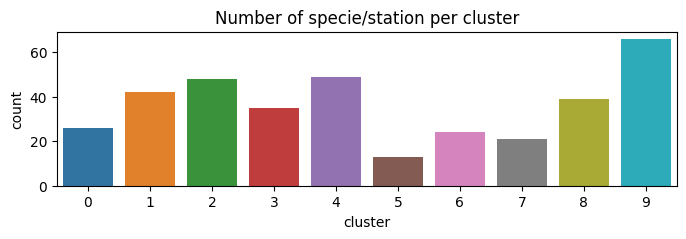

In [10]:
### Load clustering data
clusters = pd.read_csv("../data/clustering_intervals.csv")

print(clusters.shape)
display(clusters.sample(3))

plt.figure(figsize=(8,2))
plt.title("Number of specie/station per cluster")
sns.countplot(x=clusters["cluster"]);

### Load dataset

In [11]:
### From BigQuery
# bq_client = bigquery.Client.from_service_account_json("data/arpae-prod-ml-f7820c528250.json")
# sql = f"SELECT * FROM `{PROJECT_ID}.{JOINED_BQ_DATASET}.{JOINED_DATA_TABLE}`"
# df_dataset = _run_query(bq_client, sql)

### From local file
df_dataset = pd.read_feather("../data/dataset_7D_normalized_2023.feather")

In [12]:
# Join Cluster label
# df_dataset = pd.merge(df_dataset, clusters, on=["station_id", "pol_var_id"], how="inner")

# Convert dates, sort and set index
df_dataset.date = pd.to_datetime(df_dataset.date)
df_dataset.sort_values(["station_id", "pol_var_id", "date"], inplace=True)
df_dataset.dropna(inplace=True)
df_dataset.set_index("date", inplace=True)

In [13]:
### Dataset preview
print(df_dataset.shape)
df_dataset.head(5)

(1178889, 99)


,station_id,pol_var_id,B13011_min_amin,B13011_max_amax,B13011_mean_mean,B13011_std_mean,B13011_sum_sum,B14198_min_amin,B14198_max_amax,B14198_mean_mean,...,pol_var_id_B48034,pol_var_id_B48036,pol_var_id_B48037,pol_var_id_B48038,pol_var_id_B48039,pol_var_id_B48041,pol_var_id_B48044,pol_var_id_B48045,WHICH,cluster
date,,,,,,,,,,,,,,,,,,,,,
2006-09-05 00:00:00+00:00,1,B48001,0.0,0.010309,0.007163,0.010346,5.140287e-03,0.555556,0.707631,0.648377,...,0,0,0,0,0,0,0,0,training,3
2006-09-06 00:00:00+00:00,1,B48001,0.0,0.010309,0.001791,0.004397,1.285072e-03,0.555556,0.707631,0.644707,...,0,0,0,0,0,0,0,0,training,3
2006-09-07 00:00:00+00:00,1,B48001,0.0,0.000000,0.000000,0.000000,6.087323e-17,0.555556,0.684836,0.625042,...,0,0,0,0,0,0,0,0,training,3
2006-09-08 00:00:00+00:00,1,B48001,0.0,0.017182,0.015519,0.011157,1.113729e-02,0.555556,0.677899,0.585648,...,0,0,0,0,0,0,0,0,training,3
2006-09-09 00:00:00+00:00,1,B48001,0.0,0.044674,0.031038,0.037994,2.227458e-02,0.555556,0.679881,0.582157,...,0,0,0,0,0,0,0,0,training,3


___

# 2. Define training parameters

In [14]:
all_features = [
    # 'station_id', 'pol_var_id', 'pol_value_label',
    # 'season_label', 'seasonal_mean', 'seasonal_prev_1',
    # 'trend_label', 'trend_mean', 'trend_prev_1',
    # 'residual_label', 'residual_mean', 'residual_prev_1',
    'week_amax',
    'B13011_min_amin', 'B13011_max_amax', 'B13011_mean_mean', 'B13011_std_mean', 'B13011_sum_sum',
    'B14198_min_amin', 'B14198_max_amax', 'B14198_mean_mean', 'B14198_std_mean', 'B14198_sum_sum',
    #'TEMP_min_amin', 'TEMP_max_amax', 'TEMP_mean_mean', 'TEMP_std_mean', 'TEMP_sum_sum',
    'station_lat_amax', 'station_lon_amax', 'station_H_piano_strada_amax', 'station_H_mslm_amax',
    #'PREC_amin', 'PREC_mean', 'PREC_std', 'PREC_median', 'PREC_amax', 'PREC_skew', 'PREC_kurtosis',
    'pol_value_amin', 'pol_value_mean', 'pol_value_std', 'pol_value_median', 'pol_value_amax', 'pol_value_skew', 'pol_value_kurtosis',
    'pol_value_prev_1', 'pol_value_prev_2', 'pol_value_prev_3', 'pol_value_prev_4', 'pol_value_prev_5', 'pol_value_prev_6', 'pol_value_prev_7',
    'station_id_1', 'station_id_2', 'station_id_4', 'station_id_5', 'station_id_6', 'station_id_7', 'station_id_8', 'station_id_9', 'station_id_10', 'station_id_11', 'station_id_13',
    'pol_var_id_B48001', 'pol_var_id_B48002', 'pol_var_id_B48003', 'pol_var_id_B48005', 'pol_var_id_B48006', 'pol_var_id_B48007', 'pol_var_id_B48008', 'pol_var_id_B48011', 'pol_var_id_B48012', 'pol_var_id_B48013', 'pol_var_id_B48015', 'pol_var_id_B48016', 'pol_var_id_B48017', 'pol_var_id_B48018', 'pol_var_id_B48019', 'pol_var_id_B48021', 'pol_var_id_B48023', 'pol_var_id_B48024', 'pol_var_id_B48025', 'pol_var_id_B48026', 'pol_var_id_B48029', 'pol_var_id_B48030', 'pol_var_id_B48031', 'pol_var_id_B48032', 'pol_var_id_B48033', 'pol_var_id_B48034', 'pol_var_id_B48036', 'pol_var_id_B48037', 'pol_var_id_B48038', 'pol_var_id_B48039', 'pol_var_id_B48041', 'pol_var_id_B48044', 'pol_var_id_B48045'
]

y_label = "pol_value_label"

print(f"Len features: {len(all_features)}")
print(f"y_label: {y_label}")

Len features: 73
y_label: pol_value_label


In [15]:
def get_dataset(cluster_n, params):
    # Create an object to store dataset and results
    class dataset: pass
    dataset.cluster_n = cluster_n

    # Create cluster training/test/validation split
    df_feature = df_dataset[df_dataset.cluster == cluster_n].copy()
    dataset.x_train = df_feature
    dataset.y_train = df_feature[[y_label]]

    # dataset.x_valid = df_feature[df_feature.WHICH == "validation"]
    # dataset.y_valid = df_feature[df_feature.WHICH == "validation"][[y_label]]
    # dataset.x_test = df_feature[df_feature.WHICH == "test"]
    # dataset.y_test = df_feature[df_feature.WHICH == "test"][[y_label]]
    
    # Drop all-0 columns (one hot encodings)
    to_keep = [c for c in dataset.x_train.columns if dataset.x_train[c].any()]
    dataset.features = [feature for feature in all_features if feature in to_keep]

    dataset.train_dataset = timeseries_dataset_from_array(dataset.x_train[dataset.features], dataset.y_train, sequence_length=params.sequence_length, batch_size=params.batch_size)
    #dataset.valid_dataset = timeseries_dataset_from_array(dataset.x_valid[dataset.features], dataset.y_valid, sequence_length=params.sequence_length, batch_size=params.batch_size)
    #dataset.test_dataset = timeseries_dataset_from_array(dataset.x_test[dataset.features], dataset.y_test, sequence_length=params.sequence_length, batch_size=params.batch_size)

    return dataset

___

# 3. Model structure definition
* LSTM + MultiHeadAttention

In [16]:
model_arch_name = "LSTM+MultiHeadAttention+AdamW"

def get_model(params, feature_len):
    # Define model inputs
    input_layer = tf.keras.layers.Input(shape=(params.sequence_length, feature_len))

    # LSTM Layer
    lstm_1 = tf.keras.layers.LSTM(units=params.lstm_1_units, dropout=params.dropout, return_sequences=True)(input_layer)
    lstm_2 = tf.keras.layers.LSTM(units=params.lstm_2_units, dropout=params.dropout, return_sequences=True)(lstm_1)

    ### Multi head attention
    attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(query=lstm_2, value=lstm_2, key=lstm_2)
    attn_output = tf.keras.layers.Dense(units=params.dense_1_units)(attn_layer)

    # Reshape attention layer
    att_reshape = tf.keras.layers.Flatten()(attn_output)

    # Dense layer
    dense_lst_1 = tf.keras.layers.Dense(units=params.dense_1_units)(att_reshape)
    dropout_1 = tf.keras.layers.Dropout(params.dropout)(dense_lst_1)
    dense_lst_2 = tf.keras.layers.Dense(units=params.dense_2_units)(dropout_1)

    # Output layer
    output_layer = tf.keras.layers.Dense(units=1)(dense_lst_2)

    # Define model architecture
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    # Optimizer
    optimizer = AdamW(learning_rate=params.learning_rate)
    model.compile(optimizer=optimizer, loss="mse")
    return model

In [25]:
def train_model(dataset, params):
    model_name = f"final_{model_arch_name}_Cluster-{dataset.cluster_n}"
    print(f"Training model {model_name}")

    # Load model and fit dataset
    model = get_model(params=params, feature_len=len(dataset.features))

    history = model.fit(
        dataset.train_dataset,
        epochs=params.n_epochs,
        shuffle=params.shuffle,
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=params.patience, verbose=1, mode="min", restore_best_weights=True),
            ModelCheckpoint(f"{model_output}/{model_name}.h5", monitor="val_loss", mode="min", save_best_only=True),
            TqdmCallback(verbose=1),
        ],
    )
    
    model.save(f"{model_output}/{model_name}.h5")

    return history, model

___

# 4. Training

In [18]:
### Choose clusters for training and test
all_clusters = sorted(clusters.cluster.unique())

# for debugging purpose
# all_clusters = random.sample(all_clusters, 1)

print(f"Training on clusters: {all_clusters}")

Training on clusters: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [19]:
# Model parameters
class model_params:
    lstm_1_units = 512
    lstm_2_units = 128
    dense_1_units = 256
    dense_2_units = 256
    dropout = .2
    learning_rate = 0.001
    batch_size = 1024
    sequence_length = 7
    n_epochs = 100
    patience = 10
    shuffle = True

In [26]:
trainings = []
for cluster_n in tqdm(all_clusters):
    # Setup comet experiment
    experiment = Experiment(
        api_key=COMET_API_KEY,
        project_name=project_name,
        workspace=comet_ml_workspace,
    )
    
    experiment_name = f"{model_arch_name}_Cluster-{cluster_n}"
    experiment.set_name(experiment_name)
    
    # Load dataset
    dataset = get_dataset(cluster_n=cluster_n, params=model_params)

    # Fit model on dataset, store results
    dataset.history, dataset.model = train_model(dataset, model_params)
    trainings.append(dataset)
    
    experiment.end()

  0%|          | 0/10 [00:00<?, ?it/s]

Training model final_LSTM+MultiHeadAttention+AdamW_Cluster-0


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model final_LSTM+MultiHeadAttention+AdamW_Cluster-1


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model final_LSTM+MultiHeadAttention+AdamW_Cluster-2


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model final_LSTM+MultiHeadAttention+AdamW_Cluster-3


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model final_LSTM+MultiHeadAttention+AdamW_Cluster-4


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model final_LSTM+MultiHeadAttention+AdamW_Cluster-5


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model final_LSTM+MultiHeadAttention+AdamW_Cluster-6


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model final_LSTM+MultiHeadAttention+AdamW_Cluster-7


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model final_LSTM+MultiHeadAttention+AdamW_Cluster-8


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model final_LSTM+MultiHeadAttention+AdamW_Cluster-9


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

## 4.1 Loss training history

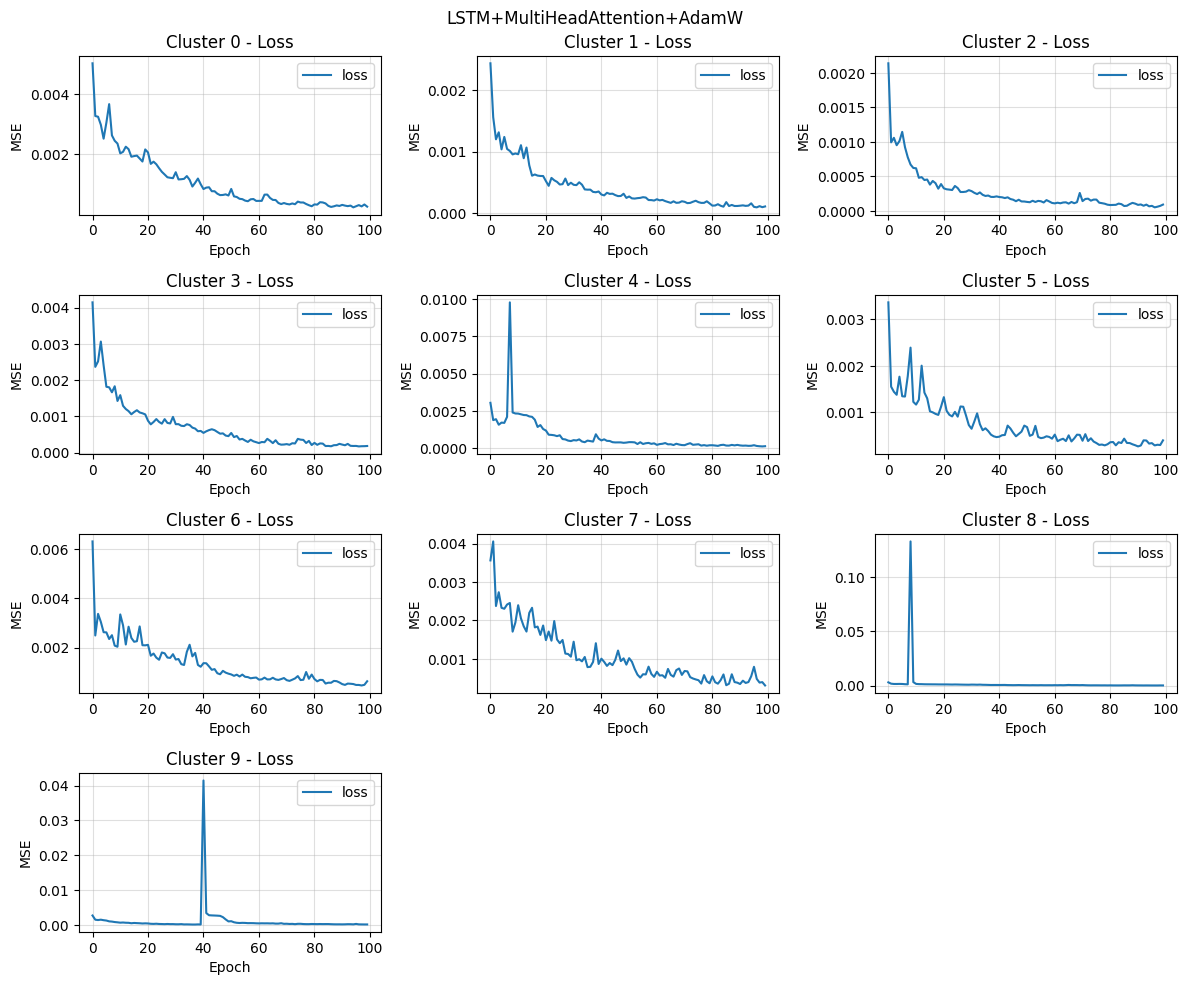

In [29]:
rows, cols = 5, 3
fig, axs = plt.subplots(rows, cols, figsize=(12, 12), squeeze=False)
plt.suptitle(model_arch_name)
for subpltn, dataset in enumerate(trainings):
    ax = axs[divmod(subpltn, cols)]
    ax.set_title(f"Cluster {dataset.cluster_n} - Loss")
    ax.plot(dataset.history.history["loss"])
    ax.set_ylabel("MSE")
    ax.set_xlabel("Epoch")
    ax.legend(["loss"], loc="upper right")
    ax.grid(alpha=0.4)
for subpltn in range(subpltn + 1, rows * cols):
    fig.delaxes(axs.flatten()[subpltn])  # removing empty plots from subplot grid
plt.tight_layout()
plt.show();